In [24]:
#python libraries
import os
import re
from datetime import datetime
import pytz
import copy

#other ML libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# Setting random seeds for reproducibility
random_seed = 420
np.random.seed(random_seed)
_ = torch.manual_seed(random_seed)

### IMPORT PBM SIMULATION

In [26]:
result_file = open("./../PBM/sim_july.csv")

#Skipping first two lines
result_file.readline()
result_file.readline()

period = result_file.readline().split()[2:10]

zone_names = result_file.readline().split()
temp_map = {key:[] for key in zone_names}
start_day, start_month, year = period[3].split('/')
start_day, start_month, year = int(start_day), int(start_month), int(year) + 2000
counter = 1
while measured_temp := result_file.readline().split():
    for i, value in enumerate(measured_temp):
        if(i == 0):
            time = value
            hour, min = time.split('h')
            hour, min = int(hour), int(min)
            day = start_day + counter//24
            if day > 31: #TODO: Brute force, FIX
                day = 1
            month = start_month + counter//(24*31)
            datetime_obj = datetime(year=year, month=month, day=day, hour=hour, minute=min, tzinfo=pytz.timezone('Etc/GMT-2'))
            temp_map[zone_names[i]].append(datetime_obj)
        else:
            temp = value
            temp_map[zone_names[i]].append(float(temp))
    counter += 1

In [27]:
sim_temp = pd.DataFrame(temp_map)
sim_temp["Time"] = pd.to_datetime(sim_temp['Time'],  utc=True).dt.tz_convert('Etc/GMT-2')
sim_temp = sim_temp.set_index('Time')

rename_map = {"Time": "timestamp",
              "Ambientdb(C)(C)": "1OutdoorEntrance_temperature",
              "gfSleepdbT(C)": "0BRoom_temperature",
              "gfLivRoomdbT(C)": "0BTLivingRoom_temperature",
              "1fEntrancedbT(C)": "1Entrance_temperature",
              "1fSleep1dbT(C)": "1GuestRoom_temperature",
              "1fSleep2dbT(C)": "1MainRoom_temperature",
              "2fLivRoomdbT(C)": "2LivingRoomCenter_temperature",
              "2fOfficedbT(C)": "2OfficeDesk_temperature"}

sim_temp = sim_temp.reset_index()[rename_map.keys()].rename(columns=rename_map).set_index("timestamp").sort_index(axis=1)
sim_temp['2Fireplace_temperature'] = sim_temp['2LivingRoomCenter_temperature']
sim_temp['2Cooking_temperature'] = sim_temp['2LivingRoomCenter_temperature']
sim_temp.head(2)

,0BRoom_temperature,0BTLivingRoom_temperature,1Entrance_temperature,1GuestRoom_temperature,1MainRoom_temperature,1OutdoorEntrance_temperature,2LivingRoomCenter_temperature,2OfficeDesk_temperature,2Fireplace_temperature,2Cooking_temperature
timestamp,,,,,,,,,,
2022-07-01 01:00:00+02:00,23.62,24.99,25.88,24.46,25.44,20.85,29.65,30.38,29.65,29.65
2022-07-01 02:00:00+02:00,23.41,24.81,25.78,24.29,25.79,20.45,28.90,29.73,28.90,28.90


### DATA CLEANING

In [28]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### EXPLORATORY DATA ANALYSIS ###

<AxesSubplot: xlabel='timestamp'>

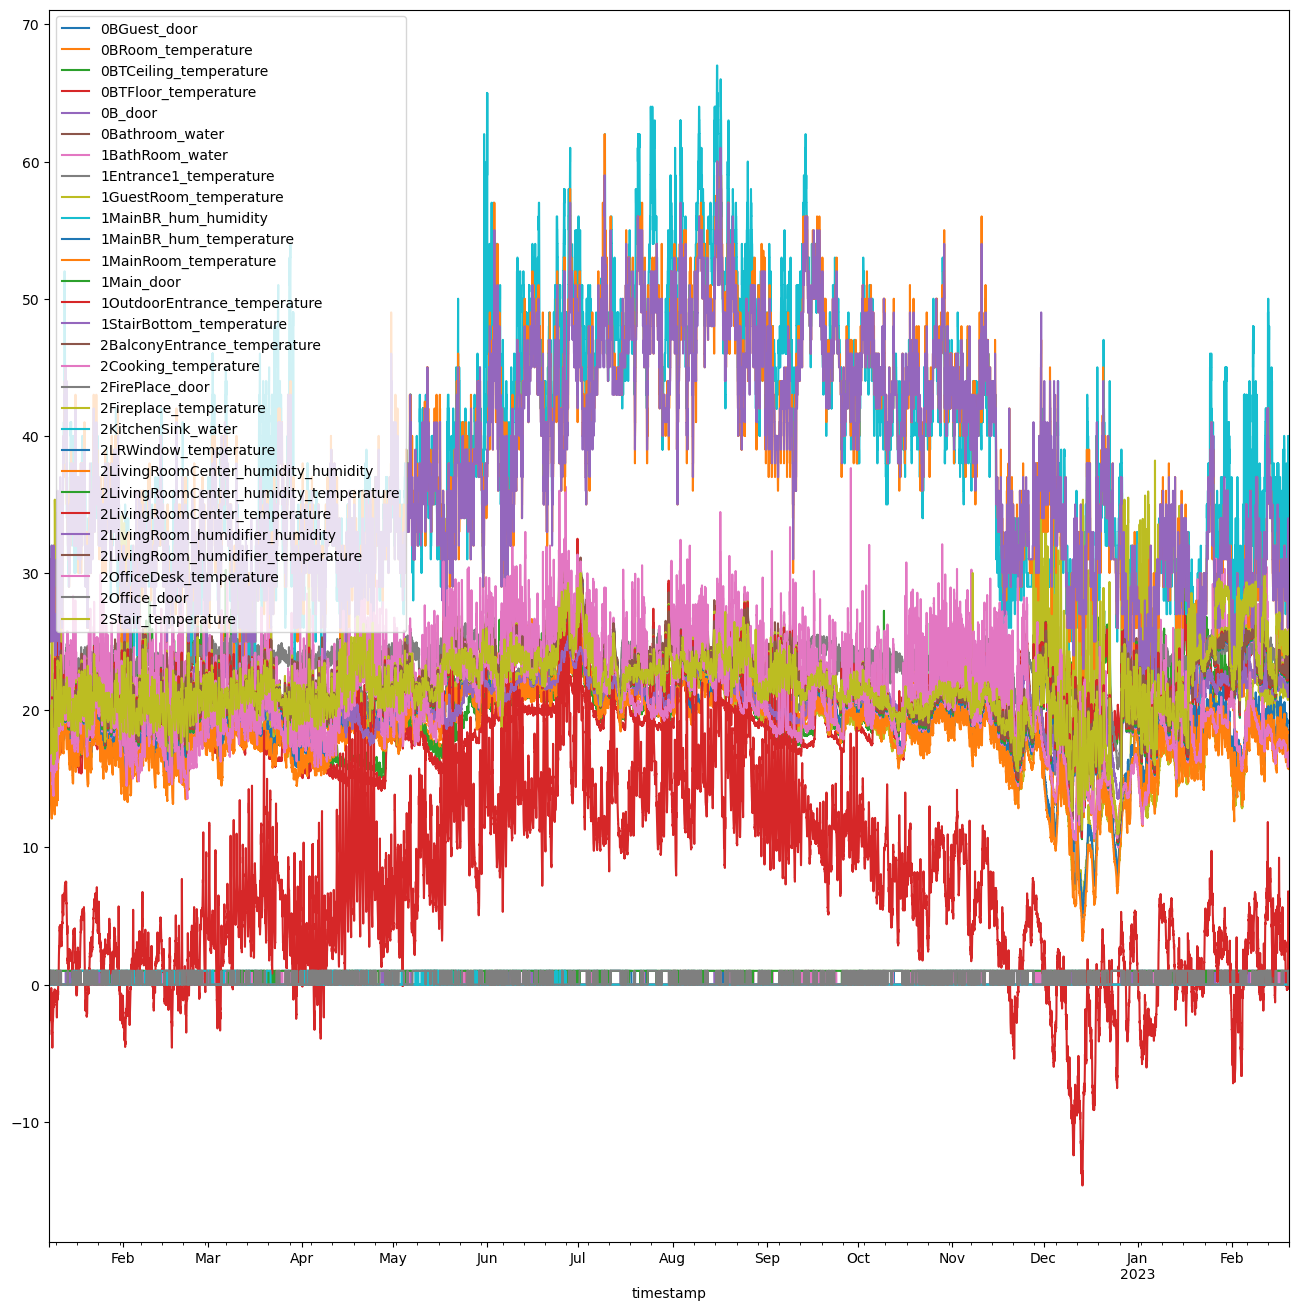

In [29]:
#plot the data
sensor_data.plot(figsize=(16, 16))

### FEATURE ENGINEERING ###

In [30]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

In [31]:
sensor_data.describe()

,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,0Bathroom_water,1BathRoom_water,1Entrance1_temperature,1GuestRoom_temperature,1MainBR_hum_humidity,...,2LivingRoom_humidifier_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,sin_daily,cos_daily,sin_yearly,cos_yearly,sin_weekly,cos_weekly
count,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,...,39166.000000,39166.000000,39166.000000,39166.000000,3.916600e+04,3.916600e+04,39166.000000,39166.000000,39166.000000,39166.000000
mean,0.731093,20.219920,20.493444,19.880145,0.159577,0.003396,0.113925,23.061776,18.888458,38.371860,...,21.596080,20.351772,0.398739,21.664779,4.776617e-05,-1.797791e-05,0.048966,0.089977,-0.004115,0.000289
std,0.443397,2.777353,2.358416,2.570392,0.366218,0.058175,0.317725,1.703731,3.133083,9.052182,...,2.549447,3.360557,0.489645,2.543805,7.071023e-01,7.071294e-01,0.686751,0.719656,0.707943,0.706275
min,0.000000,10.250000,15.100000,14.150000,0.000000,0.000000,0.000000,15.300000,5.700000,19.000000,...,10.550000,10.525000,0.000000,10.950000,-1.000000e+00,-1.000000e+00,-0.999999,-0.999979,-0.974928,-0.900969
25%,0.000000,18.800000,18.750000,18.050000,0.000000,0.000000,0.000000,22.300000,17.650000,31.000000,...,20.100000,18.383333,0.000000,20.250000,-7.071068e-01,-7.071068e-01,-0.639648,-0.641690,-0.781831,-0.900969
50%,1.000000,20.200000,20.483333,19.750000,0.000000,0.000000,0.000000,23.450000,19.200000,37.000000,...,21.550000,20.200000,0.000000,21.583333,1.224647e-16,-1.836970e-16,0.164758,0.176443,0.000000,-0.222521
75%,1.000000,22.000000,22.100000,21.650000,0.000000,0.000000,0.000000,24.250000,20.925000,45.000000,...,23.300000,22.366667,1.000000,23.116667,7.071068e-01,7.071068e-01,0.681936,0.811856,0.781831,0.623490
max,1.000000,27.450000,31.550000,27.750000,1.000000,1.000000,1.000000,26.900000,28.200000,67.000000,...,30.700000,32.425000,1.000000,30.000000,1.000000e+00,1.000000e+00,0.999986,0.999991,0.974928,1.000000


### DATA PREPROCESSING

In [32]:
data = sensor_data.copy()
cols_to_drop = ['1MainBR_hum_temperature', '2BalconyEntrance_temperature', '2LRWindow_temperature',
                '2LivingRoomCenter_humidity_temperature', '2LivingRoom_humidifier_temperature'] #due to correlation
data = data.drop(cols_to_drop, axis=1)

data["0BTLivingRoom_temperature"] = (data["0BTCeiling_temperature"] + data["0BTFloor_temperature"])/2
data = data.drop("0BTFloor_temperature", axis=1).drop("0BTCeiling_temperature", axis=1).sort_index(axis=1)

data["1Entrance_temperature"] = (data["1Entrance1_temperature"] + data["1StairBottom_temperature"])/2
data = data.drop("1Entrance1_temperature", axis=1).drop("1StairBottom_temperature", axis=1).sort_index(axis=1)

drop_hum_and_water_data = True
if drop_hum_and_water_data:
    data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)

In [33]:
train_df_1 = data.loc[(data.index.month < 7) & (data.index.year == 2022)].copy()
train_df_2 = data.loc[((data.index.month > 8) & (data.index.year == 2022))|(data.index.year == 2023)].copy()
train_df = pd.concat([train_df_1, train_df_2])
val_df = data.loc[(data.index.month == 8) & (data.index.year == 2022)].copy()
test_df = data.loc[(data.index.month == 7) & (data.index.year == 2022)].copy()

train_labels = train_df.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaler.fit(train_df)
y_scaler.fit(train_labels)

train_df_1_scaled = x_scaler.transform(train_df_1)
train_df_2_scaled = x_scaler.transform(train_df_2)
train_df_1_scaled = pd.DataFrame(train_df_1_scaled, columns=train_df.columns)
train_df_2_scaled = pd.DataFrame(train_df_2_scaled, columns=train_df.columns)
val_df_scaled = x_scaler.transform(val_df)
val_df_scaled = pd.DataFrame(val_df_scaled, columns=val_df.columns)
test_df_scaled = x_scaler.transform(test_df)
test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns)


print(f"Shape of train_df = {train_df.shape}, Shape of val_df = {val_df.shape}, Shape of test_df = {test_df.shape}")
print(f"Shape of labels = {train_labels.shape}")

Shape of train_df = (33214, 22), Shape of val_df = (2976, 22), Shape of test_df = (2976, 22)
Shape of labels = (33214, 10)


In [34]:
import WindowGenerator
import importlib
importlib.reload(WindowGenerator)

measurements_per_day = 4*24
sequence_width = measurements_per_day #24 hours
label_width = 8 #2 hours
shift = 0

label_columns = train_labels.columns

train_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift)
train_windows.add_data(train_df_1_scaled, label_columns)
train_windows.add_data(train_df_2_scaled, label_columns)
val_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift)
val_windows.add_data(val_df_scaled, label_columns)
test_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift)
test_windows.add_data(test_df_scaled, label_columns)

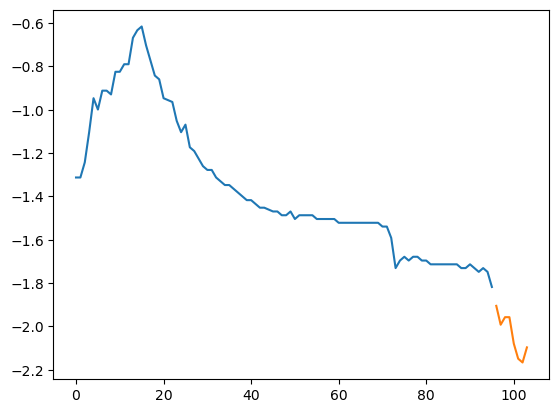

In [35]:
n = 0
x_1 = train_windows[n][0][:,1]
x_2 = train_windows[n][1][:,0]
plt.plot(range(len(x_1)), x_1)
plt.plot(range(len(x_1), len(x_1)+len(x_2)), x_2)

In [36]:
batch_size = 1000
train_loader = DataLoader(train_windows, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_windows, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_windows, batch_size=len(test_windows), shuffle=False)

X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1000, 96, 22])
Target shape: torch.Size([1000, 8, 10])


### DOOR MODEL

In [37]:
feature_mask = train_df.columns.str.endswith('door')
feature_cols = [name for i, name in enumerate(train_df.columns) if not feature_mask[i]]

train_features_door = train_df[feature_cols].copy()
val_features_door = val_df[feature_cols].copy()
test_features_door = test_df[feature_cols].copy()

door_scaler = StandardScaler()

train_features_scaled_door = door_scaler.fit_transform(train_features_door)
val_features_scaled_door = door_scaler.transform(val_features_door)
test_features_scaled_door = door_scaler.transform(test_features_door)

train_labels_door = train_df.loc[:, train_df.columns.str.endswith('door')].values
val_labels_door = val_df.loc[:, val_df.columns.str.endswith('door')].values
test_labels_door = test_df.loc[:, test_df.columns.str.endswith('door')].values

In [38]:
y_train = torch.from_numpy(train_labels_door).to(torch.float)
x_train = torch.from_numpy(train_features_scaled_door).to(torch.float)

y_val = torch.from_numpy(val_labels_door).to(torch.float)
x_val = torch.from_numpy(val_features_scaled_door).to(torch.float)

y_test = torch.from_numpy(test_labels_door).to(torch.float)
x_test = torch.from_numpy(test_features_scaled_door).to(torch.float)

train_dataset_door = torch.utils.data.TensorDataset(x_train, y_train)
train_loader_door = torch.utils.data.DataLoader(train_dataset_door, batch_size=1048, shuffle=True)

val_dataset_door = torch.utils.data.TensorDataset(x_val, y_val)
val_loader_door = torch.utils.data.DataLoader(val_dataset_door, batch_size=len(x_val), shuffle=False)

In [39]:
import FFNNModel
import importlib
importlib.reload(FFNNModel)

layers = [train_features_door.shape[1], 128, 64, train_labels_door.shape[1]]
door_model = FFNNModel.Net(layers)
print(door_model)

train_door_model = False
if train_door_model:
    epochs = 10000
    lr = 1e-4
    l2_reg = 1e-2
    door_model.train(train_loader_door, val_loader_door, epochs, lr, l2_reg)
else:
    door_model.load_state_dict(torch.load('./models/door_model'))


Net(
  (linear_layers): ModuleList(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
  (act): ReLU()
  (sigmoid): Sigmoid()
)


### LSTM

In [40]:
import LSTMModel
import importlib
importlib.reload(LSTMModel)

model = LSTMModel.Net(input_size=train_df.shape[1], hidden_size=64, output_shape=(label_width, train_labels.shape[1]),
                      num_lstm_layers=1, linear_layers=[64, 64, 64])
print(model)

epochs = 100
lr = 0.001
l1_reg = 1e-9
model.train(door_model, train_loader, val_windows, epochs, lr, l1_reg)

Net(
  (lstm): LSTM(22, 64, batch_first=True)
  (linear_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=80, bias=True)
  )
  (act): ReLU()
)


KeyboardInterrupt: 

In [41]:
save = False
if save:
    torch.save(model.state_dict(), f'./models/8_step_july_test_model')

### EXAMINE MODEL

In [ ]:
predictions = []
ground_truth = []
for input, label in val_loader:
    pred = model(input)
    predictions.append(y_scaler.inverse_transform(pred.detach().numpy().reshape(-1, 10)))
    ground_truth.append(y_scaler.inverse_transform(label.reshape(-1, 10)))


predictions = np.array(predictions[:-1])
ground_truth = np.array(ground_truth[:-1])

print('Error on validation data')

mse_val = np.mean(np.power((predictions - ground_truth), 2))
print(f'MSE:  {mse_val.item()}')

mae_val = np.mean(np.abs(predictions - ground_truth))
print(f'MAE:  {mae_val.item()}')

mape_val = 100*np.mean(np.abs(np.divide(predictions - ground_truth, ground_truth)))
print(f'MAPE: {mape_val.item()} %')

Error on validation data
MSE:  0.40752843949255013
MAE:  0.39633590499376314
MAPE: 1.6778254949539475 %


### FORECAST

In [42]:
def rolling_forecast(model, door_model, start_window, future_windows, steps, timesteps_per_step):
    temp_mask = [(column in train_labels) for column in data.columns]
    temp_indices = [i for i, x in enumerate(temp_mask) if x == True]

    cols_to_update = ['1OutdoorEntrance_temperature', 'sin_daily', 'cos_daily', 'sin_yearly',
                    'cos_yearly', 'sin_weekly', 'cos_weekly']
    cols_to_update_mask = [(column in cols_to_update) for column in data.columns]
    cols_to_update_indices = [i for i, x in enumerate(cols_to_update_mask) if x == True]

    door_mask = train_df.columns.str.endswith('door')
    door_indices = [i for i, name in enumerate(train_df.columns) if door_mask[i]]
    not_door_indices = [i for i, name in enumerate(train_df.columns) if not door_mask[i]]

    current_window = start_window.clone()

    predictions = []
    ground_truth = []
    for i in range(steps):
        next_pred = model(current_window.reshape(1, current_window.shape[0], current_window.shape[1]))
        next_state = current_window[-timesteps_per_step:].clone()
        
        for label_index, window_index in enumerate(temp_indices):
            for n, row in enumerate(next_pred[0]):
                next_state[n][window_index] = row[label_index]
        
        for window_index in cols_to_update_indices:
            for n in range(timesteps_per_step):
                if window_index == cols_to_update_indices[0]:
                    bias = float(np.random.randint(75, 125))/100
                    next_state[n][window_index] = bias*future_windows[timesteps_per_step*i][0][-(timesteps_per_step-n)][window_index]
                else:
                    next_state[n][window_index] = future_windows[timesteps_per_step*i][0][-(timesteps_per_step-n)][window_index]
        
        doors_removed = next_state[:, not_door_indices]
        door_pred = door_model(doors_removed).round()
        for door_index, window_index in enumerate(door_indices):
            for n in range(timesteps_per_step):
                next_state[n][window_index] = door_pred[n][door_index]
        current_window = torch.roll(current_window, -timesteps_per_step, dims=0)
        current_window[-timesteps_per_step:] = next_state

        predictions.append(next_pred[0].detach().numpy())
        ground_truth.append(future_windows[timesteps_per_step*i][0][-timesteps_per_step:, temp_indices].detach().numpy())
    
    for i in range(len(ground_truth)):
        ground_truth[i] = y_scaler.inverse_transform(ground_truth[i])
        predictions[i] = y_scaler.inverse_transform(predictions[i])

    input_seq = x_scaler.inverse_transform(start_window.detach().numpy())
    temp_input_seq = []
    for input in input_seq:
        temp_input_seq.append(np.array(input[temp_indices]))
    
    predictions = np.array(predictions).reshape(-1, 10).T
    ground_truth = np.array(ground_truth).reshape(-1, 10).T
    temp_input_seq = np.array(temp_input_seq).reshape(-1, 10).T
    
    return predictions, ground_truth, temp_input_seq

### JULY FORECAST

UPDATE EVERY 24H

In [80]:
import LSTMModel
import importlib
importlib.reload(LSTMModel)

july_model = LSTMModel.Net(input_size=train_df.shape[1], hidden_size=64, output_shape=(label_width, train_labels.shape[1]),
                      num_lstm_layers=1, linear_layers=[64, 64, 64])
july_model.load_state_dict(torch.load('./models/8_step_july_test_model'))
start_cond = test_windows[0][0]
steps_per_pred = 8
preds_per_day = 12

days_in_july = 31

predictions_july = np.zeros((days_in_july-2, test_windows[0][1].shape[1], preds_per_day*steps_per_pred))
ground_truths_july = np.zeros((days_in_july-2, test_windows[0][1].shape[1], preds_per_day*steps_per_pred))
temp_input_seqs_july = np.zeros((days_in_july-2, test_windows[0][1].shape[1], test_windows[0][0].shape[0]))

for i in range(days_in_july-2):
    start_index = i*steps_per_pred*preds_per_day
    update_window = test_windows[start_index][0]
    future_window = test_windows[start_index+steps_per_pred:start_index+steps_per_pred*preds_per_day+steps_per_pred]
    prediction, ground_truth, temp_input_seq = rolling_forecast(july_model, door_model, update_window, future_window, preds_per_day, steps_per_pred)
    predictions_july[i] = prediction
    ground_truths_july[i] = ground_truth
    temp_input_seqs_july[i] = temp_input_seq
    print(f"Start index: {start_index}, Forecast MAE:  {np.mean(np.abs(ground_truth - prediction))}")

print(f'Avg forecast MAE: {np.mean(np.abs(ground_truths_july-predictions_july))}')
pbm_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]
print(f'Avg forecast MAE for sensors used in PBM: {np.mean(np.abs(ground_truths_july[:, pbm_indices] - predictions_july[:, pbm_indices]))}')

predictions_july = predictions_july[:, pbm_indices]
# ground_truths_july = ground_truths_july[:, pbm_indices]

np.save('lstm_predictions_july.npy', predictions_july)

Start index: 0, Forecast MAE:  0.8835880756378174
Start index: 96, Forecast MAE:  0.8414570689201355
Start index: 192, Forecast MAE:  0.808732271194458
Start index: 288, Forecast MAE:  0.5141001343727112
Start index: 384, Forecast MAE:  0.5103880763053894
Start index: 480, Forecast MAE:  0.6295174360275269
Start index: 576, Forecast MAE:  0.6749212741851807
Start index: 672, Forecast MAE:  1.0412111282348633
Start index: 768, Forecast MAE:  0.5891571044921875
Start index: 864, Forecast MAE:  0.5107102394104004
Start index: 960, Forecast MAE:  0.9088090658187866
Start index: 1056, Forecast MAE:  0.8731573820114136
Start index: 1152, Forecast MAE:  1.153949499130249
Start index: 1248, Forecast MAE:  0.6719159483909607
Start index: 1344, Forecast MAE:  0.909991443157196
Start index: 1440, Forecast MAE:  0.5999917387962341
Start index: 1536, Forecast MAE:  0.4592880308628082
Start index: 1632, Forecast MAE:  0.672194242477417
Start index: 1728, Forecast MAE:  0.6653714776039124
Start index

In [79]:
(ground_truths_july[:, :, :7]==temp_input_seqs_july[:, :, -7:]).all()

False

In [75]:
temp_input_seqs_july[0, 0, -5:]

array([24.29999924, 24.10000038, 24.10000038, 24.10000038, 24.        ])

In [76]:
ground_truths_july[0, 0, :5]

array([24.35000038, 24.29999924, 24.29999924, 24.10000038, 24.10000038])

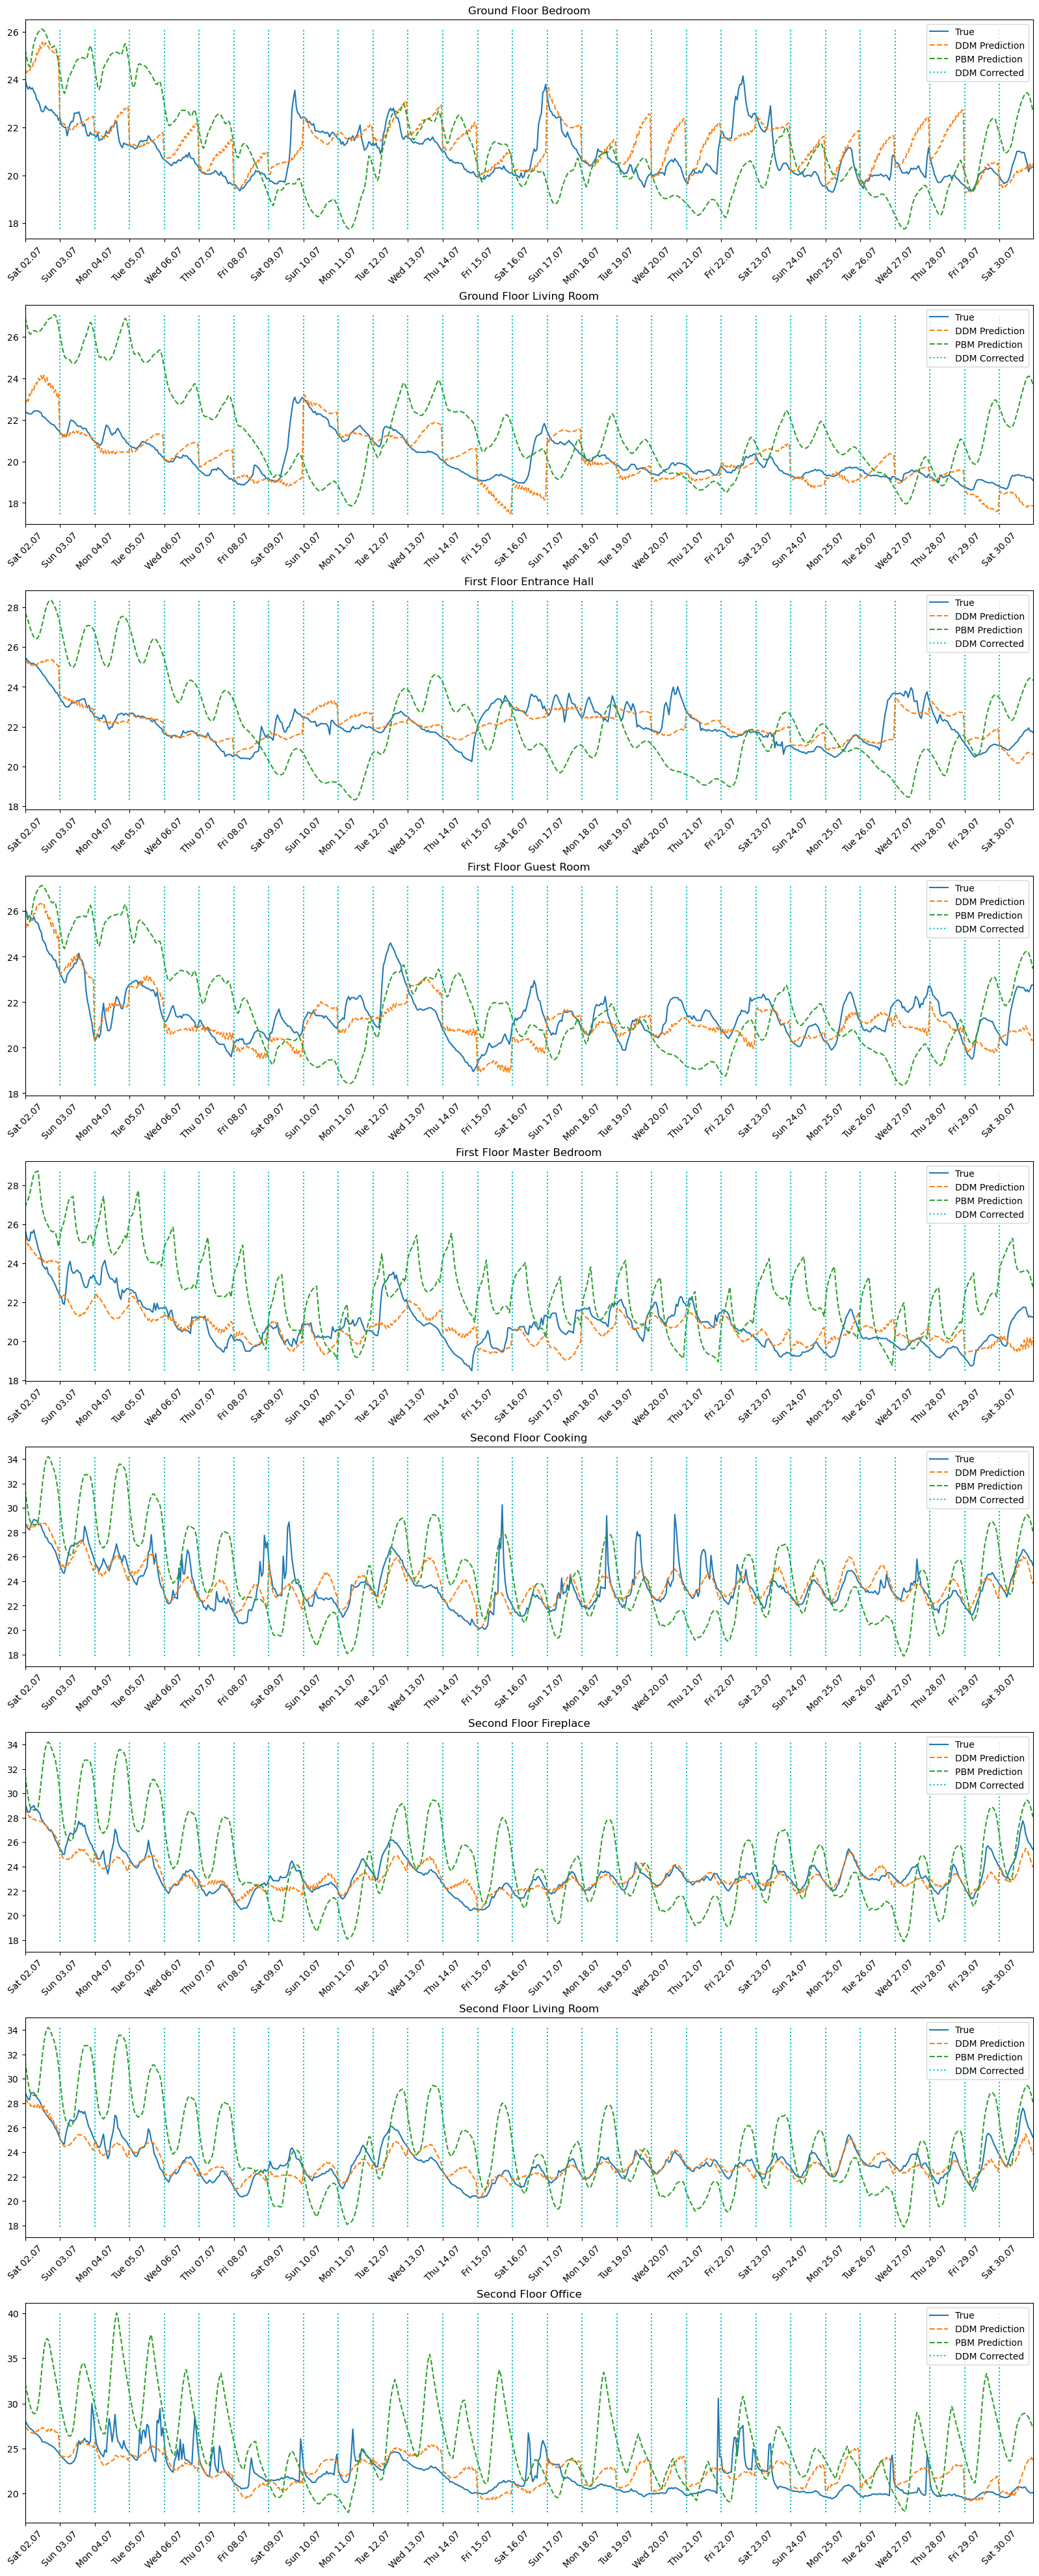

In [81]:
titles = ["Ground Floor Bedroom", "Ground Floor Living Room", "First Floor Entrance Hall",
          "First Floor Guest Room", "First Floor Master Bedroom", "Second Floor Cooking",
          "Second Floor Fireplace", "Second Floor Living Room", "Second Floor Office"]
pred_order = ['0BRoom_temperature', '0BTLivingRoom_temperature',
            '1Entrance_temperature', '1GuestRoom_temperature',
            '1MainRoom_temperature', '2Cooking_temperature',
            '2Fireplace_temperature', '2LivingRoomCenter_temperature',
            '2OfficeDesk_temperature']

plot_i = 0
fig,ax = plt.subplots(9,1,figsize=(20,50))
plt.subplots_adjust(hspace=0.3)

for i in range(predictions_july.shape[1]):
    true = ground_truths_july[:, i, :].flatten()[::4]
    ddm_pred = predictions_july[:, i, :].flatten()[::4]
    pbm_pred = sim_temp[pred_order[i]][24:-24]
    x = range(len(true))
    ax[i].plot(x, true, label="True")
    ax[i].plot(x, ddm_pred, '--', label="DDM Prediction")
    ax[i].plot(x, pbm_pred, '--', label="PBM Prediction")
    ax[i].set_title(f"{titles[i]}")
    ax[i].set_xticks(x[::24])
    ax[i].set_xticklabels([date.strftime("%a %d.%m") for date in pbm_pred.index[::24].date], rotation=45)
    ax[i].margins(x=0)
    ax[i].vlines(x = range(0, len(true), 24), ymax=np.max(np.maximum.reduce([true, ddm_pred, pbm_pred])), ymin=np.min(np.minimum.reduce([true, ddm_pred, pbm_pred])), linestyles='dotted', colors='c', label='DDM Corrected')
    ax[i].legend()

### 1 DAY FORECAST

In [43]:
steps_per_pred = 8
eight_step_model = LSTMModel.Net(input_size=train_df.shape[1], hidden_size=64, output_shape=(label_width, train_labels.shape[1]),
                      num_lstm_layers=1, linear_layers=[64, 64, 64])
eight_step_model.load_state_dict(torch.load('./models/8_step_july_test_model'))
steps_per_day = 12
pred_steps = steps_per_day
num_pred = 50

used_windows = test_windows

np.random.seed(random_seed)
eval_windows_index = np.random.choice(range(0, len(used_windows)-pred_steps*steps_per_pred-1), num_pred)

predictions_1_day = np.zeros((num_pred, used_windows[0][1].shape[1], pred_steps*steps_per_pred))
ground_truths_1_day = np.zeros((num_pred, used_windows[0][1].shape[1], pred_steps*steps_per_pred))
temp_input_seqs_1_day = np.zeros((num_pred, used_windows[0][1].shape[1], used_windows[0][0].shape[0]))

for i, start_index in enumerate(eval_windows_index):
    start_window = used_windows[start_index][0]
    future_window = used_windows[start_index+1:start_index+steps_per_pred*pred_steps+1]
    prediction, ground_truth, temp_input_seq = rolling_forecast(eight_step_model, door_model, start_window, future_window, pred_steps, steps_per_pred)
    predictions_1_day[i] = prediction
    ground_truths_1_day[i] = ground_truth
    temp_input_seqs_1_day[i] = temp_input_seq
    print(f"Start index: {start_index}, Forecast MAE:  {np.mean(np.abs(ground_truth - prediction))}")

print(f'Avg forecast MAE: {np.mean(np.abs(ground_truths_1_day-predictions_1_day))}')
pbm_indices = [0, 1, 2, 3, 4, 5, 8]
print(f'Avg forecast MAE for sensors used in PBM: {np.mean(np.abs(ground_truths_1_day[:, pbm_indices] - predictions_1_day[:, pbm_indices]))}')

Start index: 1096, Forecast MAE:  0.7255344390869141
Start index: 390, Forecast MAE:  0.5438757538795471
Start index: 575, Forecast MAE:  0.6185890436172485
Start index: 799, Forecast MAE:  0.7392281889915466
Start index: 2675, Forecast MAE:  0.879332959651947
Start index: 1966, Forecast MAE:  0.5272131562232971
Start index: 1209, Forecast MAE:  0.6147334575653076
Start index: 2202, Forecast MAE:  0.623309850692749
Start index: 266, Forecast MAE:  0.5792912840843201
Start index: 840, Forecast MAE:  0.4613434374332428
Start index: 2711, Forecast MAE:  1.0814378261566162
Start index: 1678, Forecast MAE:  0.9299300312995911
Start index: 1254, Forecast MAE:  0.6407151818275452
Start index: 724, Forecast MAE:  0.751910388469696
Start index: 803, Forecast MAE:  0.7124284505844116
Start index: 152, Forecast MAE:  0.86771559715271
Start index: 1668, Forecast MAE:  0.9136223196983337
Start index: 2496, Forecast MAE:  0.7597437500953674
Start index: 717, Forecast MAE:  0.8897519707679749
Start i

In [46]:
(ground_truths_1_day[:, :, :7]==temp_input_seqs_1_day[:, :, -7:]).all()

True

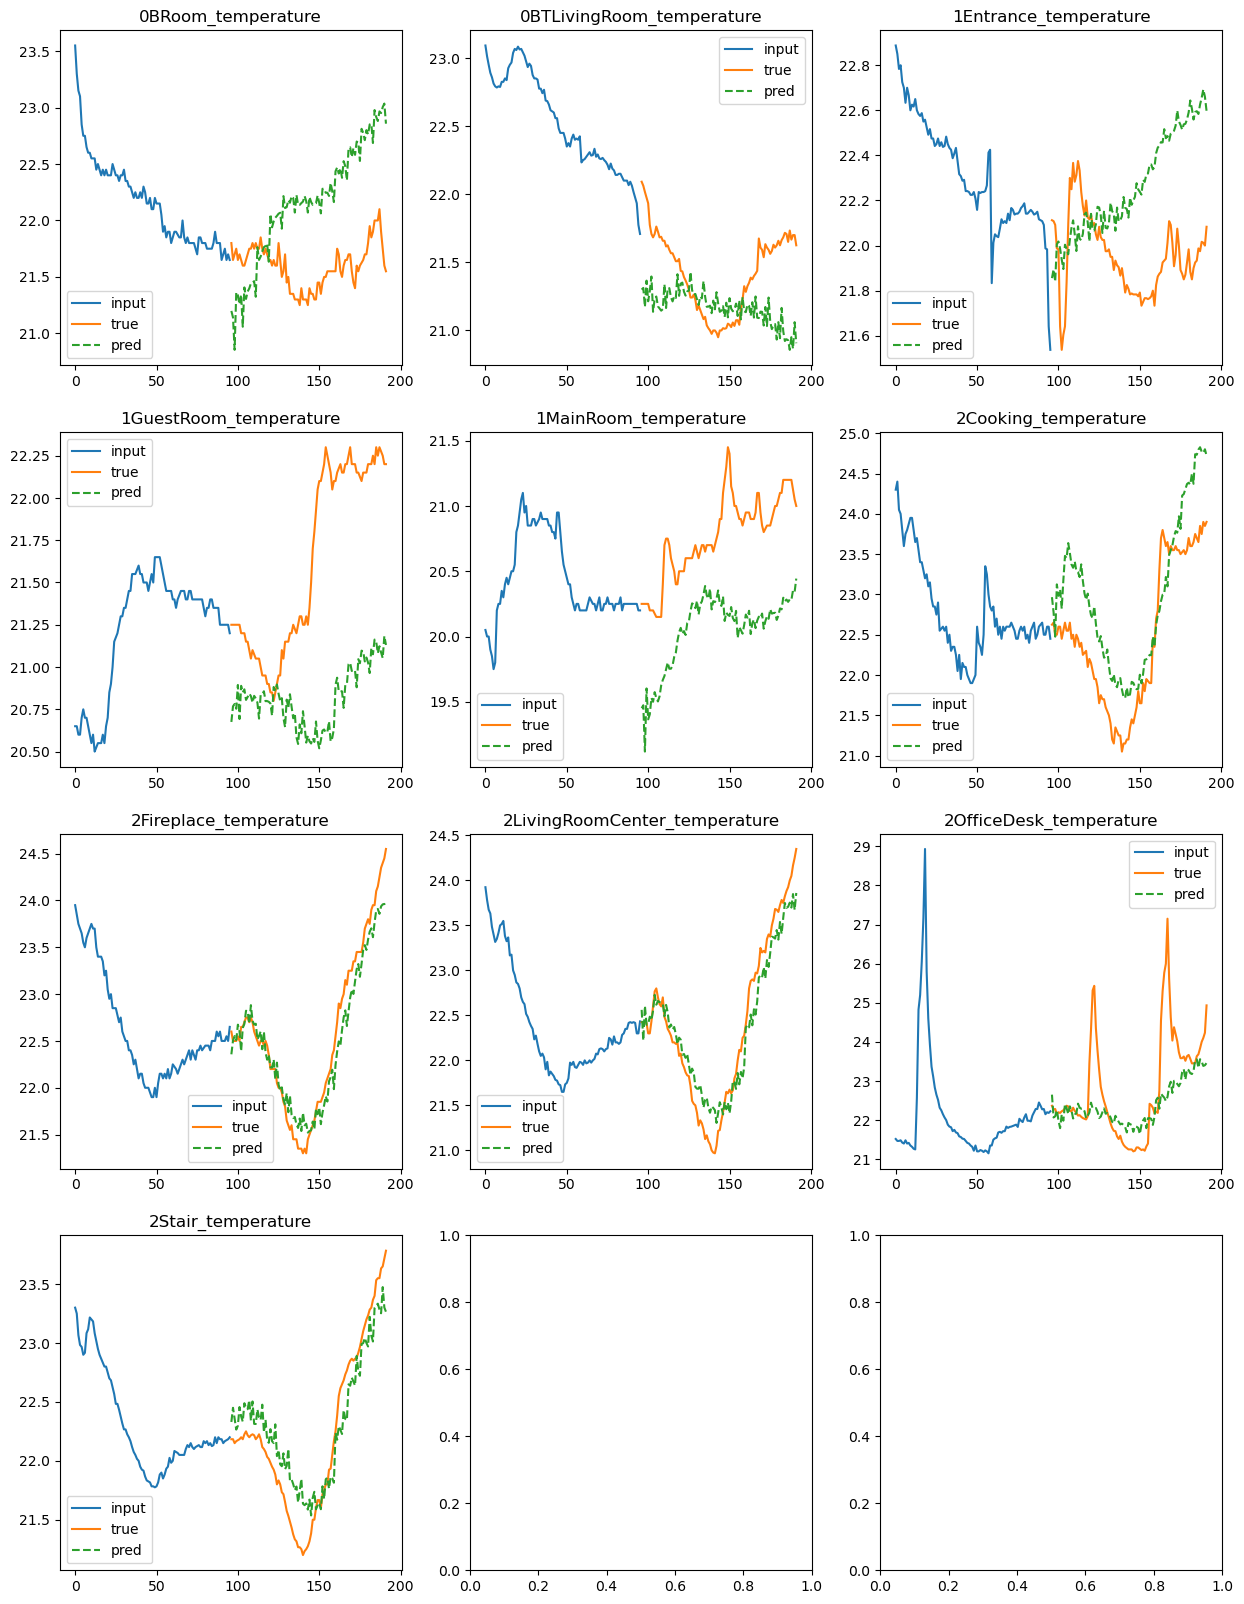

In [ ]:
plot_i = 9
fig,ax = plt.subplots(4,3,figsize=(15,20))
for i in range(predictions_1_day.shape[1]):
    input_indices = range(len(start_window))
    pred_indices = range(len(input_indices), len(input_indices) + 8*12)
    ax[i//3, i%3].plot(input_indices, temp_input_seqs_1_day[plot_i][i], label="input")
    ax[i//3, i%3].plot(pred_indices, ground_truths_1_day[plot_i][i], label="true")
    ax[i//3, i%3].plot(pred_indices, predictions_1_day[plot_i][i], '--', label="pred")
    ax[i//3, i%3].set_title(f"{train_labels.columns[i]}")
    ax[i//3, i%3].legend()

### 2 DAYS FORECAST

In [ ]:
steps_per_pred = 8
eight_step_model = LSTMModel.Net(input_size=train_df.shape[1], hidden_size=64, output_shape=(label_width, train_labels.shape[1]),
                      num_lstm_layers=1, linear_layers=[64, 64, 64])
eight_step_model.load_state_dict(torch.load('./models/8_step_july_test_model'))
steps_per_day = 12
pred_steps = steps_per_day*2
num_pred = 5

used_windows = test_windows

np.random.seed(random_seed)
eval_windows_index = np.random.choice(range(0, len(used_windows)-pred_steps*steps_per_pred-1), num_pred)

predictions_2_day = np.zeros((num_pred, used_windows[0][1].shape[1], pred_steps*steps_per_pred))
ground_truths_2_day = np.zeros((num_pred, used_windows[0][1].shape[1], pred_steps*steps_per_pred))
temp_input_seqs_2_day = np.zeros((num_pred, used_windows[0][1].shape[1], used_windows[0][0].shape[0]))

for i, start_index in enumerate(eval_windows_index):
    start_window = used_windows[start_index][0]
    future_window = used_windows[start_index+1:start_index+steps_per_pred*pred_steps+1]
    prediction, ground_truth, temp_input_seq = rolling_forecast(eight_step_model, door_model, start_window, future_window, pred_steps, steps_per_pred)
    predictions_2_day[i] = prediction
    ground_truths_2_day[i] = ground_truth
    temp_input_seqs_2_day[i] = temp_input_seq
    print(f"Start index: {start_index}, Forecast MAE:  {np.mean(np.abs(ground_truth - prediction))}")

print(f'Avg forecast MAE: {np.mean(np.abs(ground_truths_2_day-predictions_2_day))}')
pbm_indices = [0, 1, 2, 3, 4, 5, 8]
print(f'Avg forecast MAE for sensors used in PBM: {np.mean(np.abs(ground_truths_2_day[:, pbm_indices] - predictions_2_day[:, pbm_indices]))}')

Start index: 1096, Forecast MAE:  1.3533146381378174
Start index: 390, Forecast MAE:  0.7662205100059509
Start index: 575, Forecast MAE:  1.0136076211929321
Start index: 799, Forecast MAE:  0.756123423576355
Start index: 2675, Forecast MAE:  1.0534305572509766
Avg forecast MAE: 0.9885393746693929
Avg forecast MAE for sensors used in PBM: 1.074213912657329


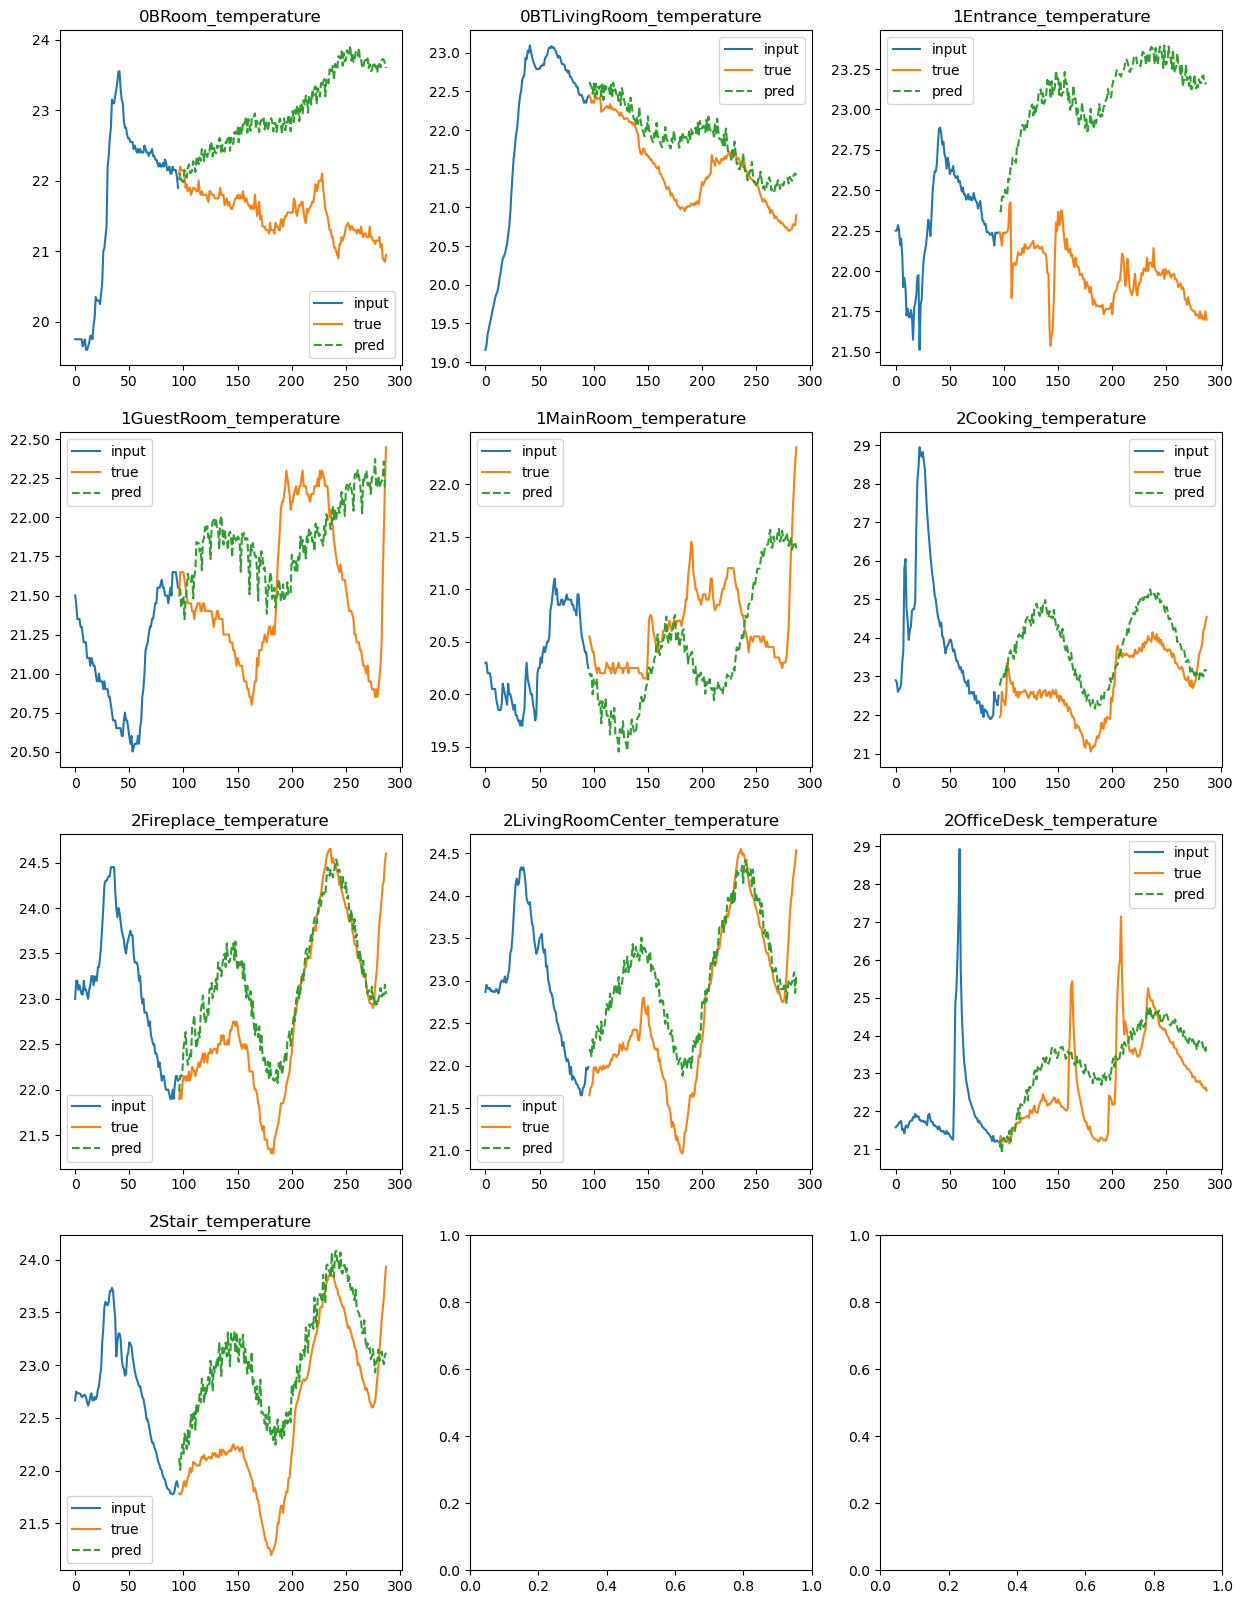

In [ ]:
plot_i = 3
fig,ax = plt.subplots(4,3,figsize=(15,20))
for i in range(predictions_2_day.shape[1]):
    input_indices = range(len(start_window))
    pred_indices = range(len(input_indices), len(input_indices) + 8*24)
    ax[i//3, i%3].plot(input_indices, temp_input_seqs_2_day[plot_i][i], label="input")
    ax[i//3, i%3].plot(pred_indices, ground_truths_2_day[plot_i][i], label="true")
    ax[i//3, i%3].plot(pred_indices, predictions_2_day[plot_i][i], '--', label="pred")
    ax[i//3, i%3].set_title(f"{train_labels.columns[i]}")
    ax[i//3, i%3].legend()